In [1]:
pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 19.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.


In [2]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 13.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler

import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [4]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Pre-Loading
y_train = pd.read_csv("FE results/y_train.csv")
y_train = y_train.drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("FE results/y_test.csv")
y_test = y_test.drop(columns=['Unnamed: 0'])


# Load Data
X_train = pd.read_csv("FE results/Train_original.csv")
Train_date = X_train['Date']
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_original.csv")
Test_date = X_test['Date']
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])

# Initialize scaler
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Normalize features
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

def create_sequences(input_data, target_data, n_steps):
    X, y = [], []
    for i in range(len(input_data) - n_steps):
        X.append(input_data[i:i+n_steps])
        y.append(target_data[i+n_steps, 0])
    return np.array(X), np.array(y)

n_steps = 7
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, n_steps)



In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input

def create_lstm_model(input_shape, lstm_units, dropout_rate, optimizer):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(lstm_units, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(lstm_units),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mse')
    return model


In [6]:
from optuna.samplers import GridSampler

def run_optuna_optimization_grid_search(X_train, y_train, X_test, y_test, n_steps):
    def lstm_objective(trial):

        lstm_units = trial.suggest_categorical('lstm_units', [50, 100])
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.2)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.01, log=True)


        # Model definition
        model = create_lstm_model(input_shape=(n_steps, X_train_seq.shape[2]),
                                  lstm_units=lstm_units,
                                  dropout_rate=dropout_rate,
                                  optimizer=Adam(learning_rate=learning_rate))

        # Train the model
        model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=64, validation_split=0.2, verbose=0)

        # Evaluate
        train_pred_scaled = model.predict(X_train_seq)
        test_pred_scaled = model.predict(X_test_seq)
        train_pred = scaler_y.inverse_transform(train_pred_scaled)
        test_pred = scaler_y.inverse_transform(test_pred_scaled)

        # Metrics
        train_mae = mean_absolute_error(y_train[n_steps:], train_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train[n_steps:], train_pred))
        test_mae = mean_absolute_error(y_test[n_steps:], test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test[n_steps:], test_pred))

        trial.set_user_attr('train_mae', train_mae)
        trial.set_user_attr('train_rmse', train_rmse)
        trial.set_user_attr('test_mae', test_mae)
        trial.set_user_attr('test_rmse', test_rmse)

        return test_rmse

    # Grid search space
    search_space = {
        'lstm_units': [50, 100],
        'dropout_rate': [0.1, 0.2],
        'learning_rate': [0.001, 0.01]
    }

    # Optuna study with GridSampler
    study = optuna.create_study(direction='minimize', sampler=GridSampler(search_space))
    study.optimize(lstm_objective, n_trials=8)

    best_trial = study.best_trial
    # Re-train the best model to get predictions for visualization
    best_params = best_trial.params
    model = create_lstm_model(
        input_shape=(n_steps, X_train_seq.shape[2]),
        lstm_units=best_params['lstm_units'],
        dropout_rate=best_params['dropout_rate'],
        optimizer=Adam(learning_rate=best_params['learning_rate'])
     )
    model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=64, validation_split=0.2, verbose=0)


   # After retraining the best model
    train_pred = scaler_y.inverse_transform(model.predict(X_train_seq))
    test_pred = scaler_y.inverse_transform(model.predict(X_test_seq))
    pred_list = {'train_pred': train_pred, 'test_pred': test_pred}

# Recalculate metrics for the retrained model
    final_train_mae = mean_absolute_error(y_train[n_steps:], train_pred)
    final_train_rmse = np.sqrt(mean_squared_error(y_train[n_steps:], train_pred))
    final_test_mae = mean_absolute_error(y_test[n_steps:], test_pred)
    final_test_rmse = np.sqrt(mean_squared_error(y_test[n_steps:], test_pred))

# Update the results dictionary with the new metrics
    results = {
    'Feature Engineering Method': 'Method Name',  # Update with actual method name
    'Best Trial Train MAE': final_train_mae,
    'Best Trial Train RMSE': final_train_rmse,
    'Best Trial Test MAE': final_test_mae,
    'Best Trial Test RMSE': final_test_rmse,
    'Best Params': best_trial.params
    }


    return results, pred_list

In [7]:

results_total = []
predictions_total = {}
# Placeholder for method names and corresponding data files
fe_methods_data = {
    'Without Feature Engineering': ('./FE results/Train_original.csv', './FE results/Test_original.csv'),
    'Boruta': ('./FE results/Train_boruta.csv', './FE results/Test_boruta.csv'),
    'PCA': ('./FE results/Train_pca.csv', './FE results/Test_pca.csv'),
    't-SNE': ('./FE results/Train_tsne.csv', './FE results/Test_tsne.csv'),
}


for method_name, (train_file, test_file) in fe_methods_data.items():
    print(f'\n####### {method_name} #######')
    X_train = pd.read_csv(train_file).drop(columns=['Unnamed: 0', 'Date'])
    y_train = pd.read_csv("FE results/y_train.csv").drop(columns=['Unnamed: 0']).values.ravel()
    X_test = pd.read_csv(test_file).drop(columns=['Unnamed: 0', 'Date'])
    y_test = pd.read_csv("FE results/y_test.csv").drop(columns=['Unnamed: 0']).values.ravel()

    results, pred_list = run_optuna_optimization_grid_search(X_train, y_train, X_test, y_test, n_steps)
    results['Feature Engineering Method'] = method_name  # Set the method name in the results

    results_total.append(results)
    predictions_total[method_name] = pred_list  # Store predictions by method

# Convert results_total to DataFrame for easier analysis if needed
results_df = pd.DataFrame(results_total)
print(results_df)

# Now, predictions_total contains the pred_list for each feature engineering method


[I 2024-04-18 18:42:23,701] A new study created in memory with name: no-name-a2f4da78-523e-4da7-a718-38c7a8d5b65a



####### Without Feature Engineering #######
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:43:00,729] Trial 0 finished with value: 4.0736742846342215 and parameters: {'lstm_units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.01}. Best is trial 0 with value: 4.0736742846342215.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:43:18,241] Trial 1 finished with value: 5.242806635618427 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.01}. Best is trial 0 with value: 4.0736742846342215.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:43:34,915] Trial 2 finished with value: 3.759949057227169 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1, 'learning_rate': 0.01}. Best is trial 2 with value: 3.759949057227169.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:43:52,399] Trial 3 finished with value: 4.602216369135397 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1, 'learning_rate': 0.001}. Best is trial 2 with value: 3.759949057227169.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:44:09,121] Trial 4 finished with value: 9.69035630080351 and parameters: {'lstm_units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.001}. Best is trial 2 with value: 3.759949057227169.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:44:26,734] Trial 5 finished with value: 6.587868744543416 and parameters: {'lstm_units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.001}. Best is trial 2 with value: 3.759949057227169.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:44:44,144] Trial 6 finished with value: 4.643675331964188 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.001}. Best is trial 2 with value: 3.759949057227169.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:45:02,739] Trial 7 finished with value: 4.393223472360469 and parameters: {'lstm_units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.01}. Best is trial 2 with value: 3.759949057227169.


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2024-04-18 18:45:19,375] A new study created in memory with name: no-name-7c84c737-8e2d-4c4c-aaab-bb3849e7dbbf



####### Boruta #######
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:45:38,109] Trial 0 finished with value: 6.2873026040215105 and parameters: {'lstm_units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.01}. Best is trial 0 with value: 6.2873026040215105.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:45:54,833] Trial 1 finished with value: 7.420457033234274 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.001}. Best is trial 0 with value: 6.2873026040215105.


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2024-04-18 18:46:11,481] Trial 2 finished with value: 10.5697040885218 and parameters: {'lstm_units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.001}. Best is trial 0 with value: 6.2873026040215105.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:46:28,860] Trial 3 finished with value: 5.116619396982063 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.01}. Best is trial 3 with value: 5.116619396982063.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2024-04-18 18:46:45,969] Trial 4 finished with value: 4.812990098267191 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1, 'learning_rate': 0.001}. Best is trial 4 with value: 4.812990098267191.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:47:03,363] Trial 5 finished with value: 7.195309161958123 and parameters: {'lstm_units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.001}. Best is trial 4 with value: 4.812990098267191.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:47:19,612] Trial 6 finished with value: 5.724149242541185 and parameters: {'lstm_units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.01}. Best is trial 4 with value: 4.812990098267191.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:47:37,508] Trial 7 finished with value: 3.853884359290797 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1, 'learning_rate': 0.01}. Best is trial 7 with value: 3.853884359290797.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:47:54,772] A new study created in memory with name: no-name-2d7a4653-d399-4ce1-b3fe-06b13e1f64ab



####### PCA #######
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:48:12,598] Trial 0 finished with value: 4.390386257534548 and parameters: {'lstm_units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.001}. Best is trial 0 with value: 4.390386257534548.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:48:29,420] Trial 1 finished with value: 3.8271711648233584 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.001}. Best is trial 1 with value: 3.8271711648233584.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:48:46,941] Trial 2 finished with value: 4.684752263768983 and parameters: {'lstm_units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.01}. Best is trial 1 with value: 3.8271711648233584.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:49:03,516] Trial 3 finished with value: 6.2493093442906975 and parameters: {'lstm_units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.01}. Best is trial 1 with value: 3.8271711648233584.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:49:21,725] Trial 4 finished with value: 3.449870950346377 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1, 'learning_rate': 0.01}. Best is trial 4 with value: 3.449870950346377.


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:49:40,110] Trial 5 finished with value: 8.242706924896801 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1, 'learning_rate': 0.001}. Best is trial 4 with value: 3.449870950346377.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:49:57,688] Trial 6 finished with value: 6.331685536652048 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.01}. Best is trial 4 with value: 3.449870950346377.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:50:14,244] Trial 7 finished with value: 6.89420540340149 and parameters: {'lstm_units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.001}. Best is trial 4 with value: 3.449870950346377.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:50:31,321] A new study created in memory with name: no-name-f40c86c7-4e04-4cc6-a094-231e22e577be



####### t-SNE #######
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:50:47,841] Trial 0 finished with value: 4.313267580213888 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1, 'learning_rate': 0.01}. Best is trial 0 with value: 4.313267580213888.


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2024-04-18 18:51:05,084] Trial 1 finished with value: 5.544554146348753 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1, 'learning_rate': 0.001}. Best is trial 0 with value: 4.313267580213888.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:51:21,778] Trial 2 finished with value: 5.658077312920695 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.001}. Best is trial 0 with value: 4.313267580213888.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:51:38,080] Trial 3 finished with value: 5.3354802988082515 and parameters: {'lstm_units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.001}. Best is trial 0 with value: 4.313267580213888.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:51:55,281] Trial 4 finished with value: 5.515387984252085 and parameters: {'lstm_units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.01}. Best is trial 0 with value: 4.313267580213888.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2024-04-18 18:52:12,701] Trial 5 finished with value: 4.739485774025508 and parameters: {'lstm_units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.001}. Best is trial 0 with value: 4.313267580213888.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:52:30,222] Trial 6 finished with value: 6.977999107528134 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.01}. Best is trial 0 with value: 4.313267580213888.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-04-18 18:52:46,996] Trial 7 finished with value: 3.9178726801152135 and parameters: {'lstm_units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.01}. Best is trial 7 with value: 3.9178726801152135.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
    Feature Engineering Method  Best Trial Train MAE  Best Trial Train RMSE  \
0  Without Feature Engineering              2.307704               3.288016   
1                       Boruta              2.307207               3.394652   
2                          PCA              3.143613               4.648509   
3                        t-SNE              2.627202               3.772381   

   Best Trial Test MAE  Best Trial Test RMSE  \
0             3.066779              3.762650   
1             2.901449              3.740222   
2             4.368312              5.388887   
3             3.465894              4.427494   

                                         Best Params  
0  {'lstm_units': 50, 'dropout_rate': 0.1, 'learn...  
1  {'lstm_units': 50, 'dropout_rate': 0.1, 'learn...  
2  {'lstm_units': 50, 'dropout_rate': 0.1, 'learn...  
3  {'lstm_units': 100, 'dropout_rate': 0.2, 'lear...  


In [16]:
results_total


[{'Feature Engineering Method': 'Without Feature Engineering',
  'Best Trial Train MAE': 2.307703930377607,
  'Best Trial Train RMSE': 3.2880164288178104,
  'Best Trial Test MAE': 3.0667793334923372,
  'Best Trial Test RMSE': 3.762650119658263,
  'Best Params': {'lstm_units': 50,
   'dropout_rate': 0.1,
   'learning_rate': 0.01}},
 {'Feature Engineering Method': 'Boruta',
  'Best Trial Train MAE': 2.307207326863152,
  'Best Trial Train RMSE': 3.39465162824031,
  'Best Trial Test MAE': 2.90144912763672,
  'Best Trial Test RMSE': 3.7402216300168254,
  'Best Params': {'lstm_units': 50,
   'dropout_rate': 0.1,
   'learning_rate': 0.01}},
 {'Feature Engineering Method': 'PCA',
  'Best Trial Train MAE': 3.1436130779617844,
  'Best Trial Train RMSE': 4.64850946925104,
  'Best Trial Test MAE': 4.368312243115235,
  'Best Trial Test RMSE': 5.38888737124403,
  'Best Params': {'lstm_units': 50,
   'dropout_rate': 0.1,
   'learning_rate': 0.01}},
 {'Feature Engineering Method': 't-SNE',
  'Best Tri

# **Visualization**

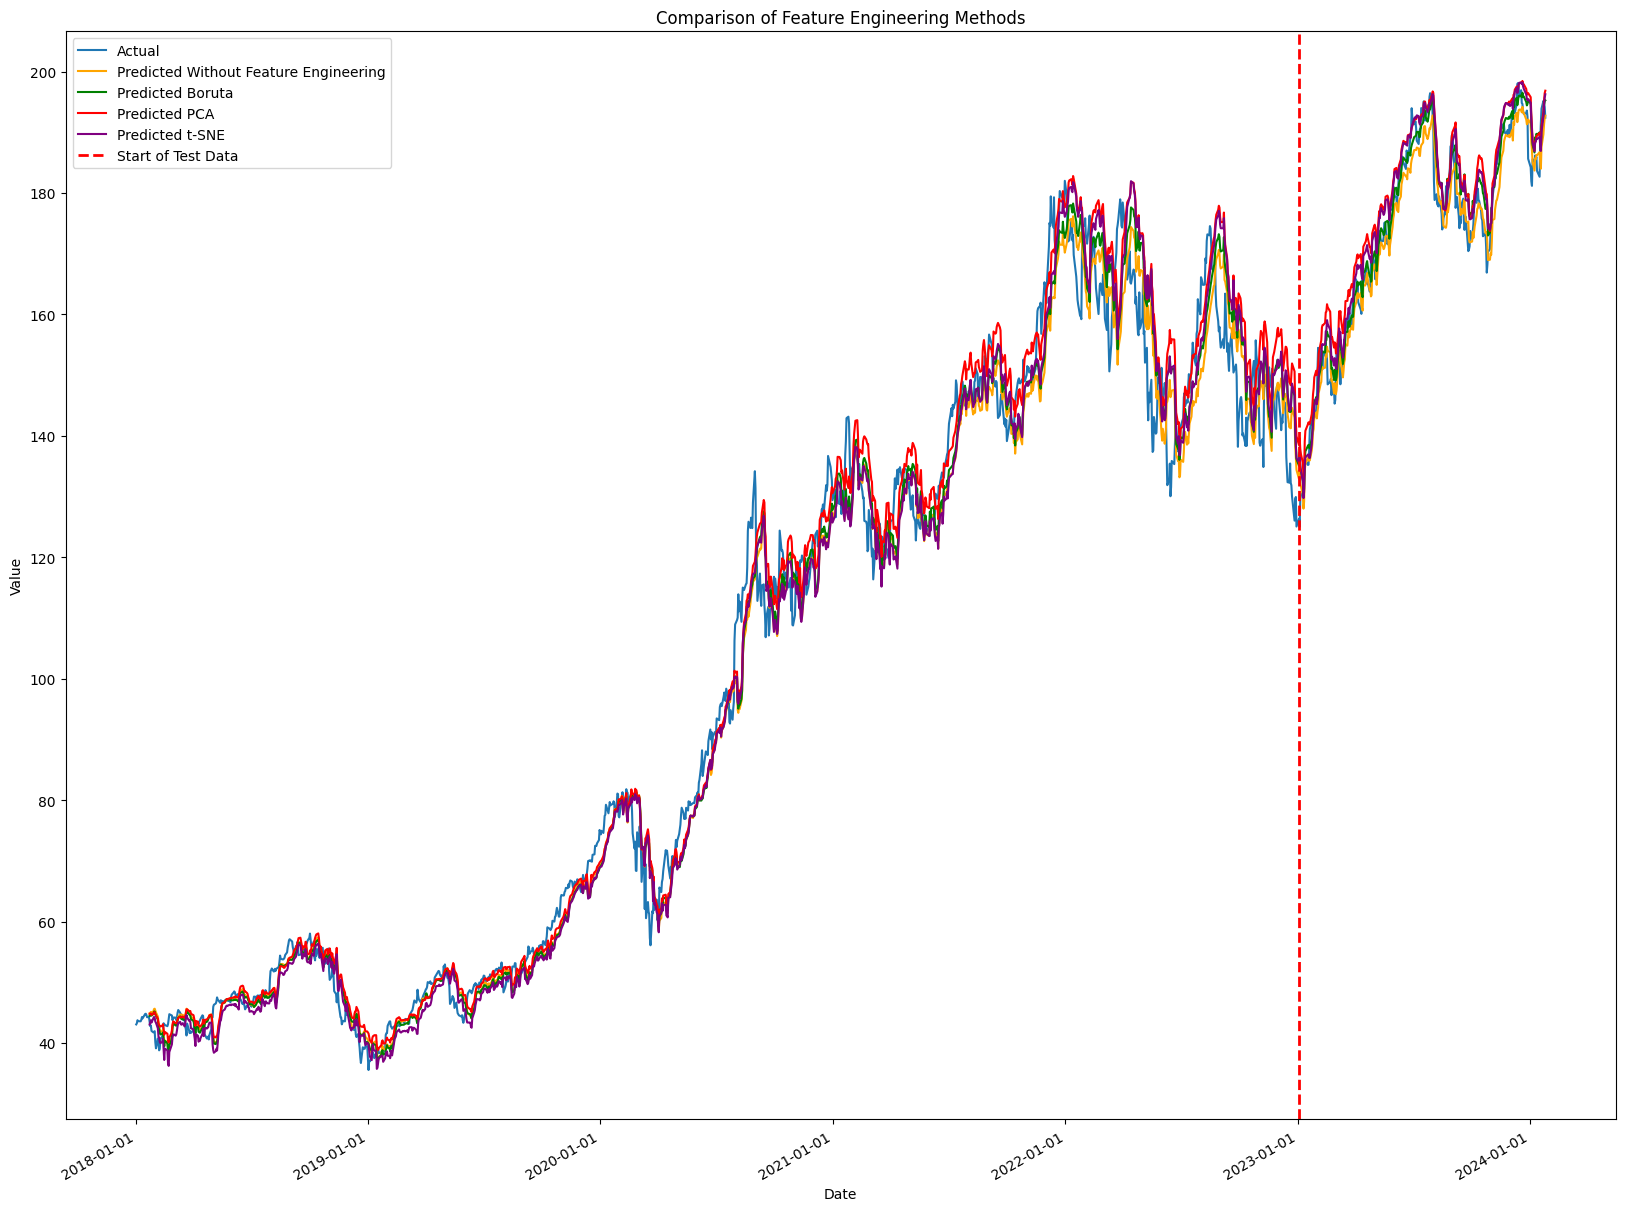

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

# Convert 'dates' to a Pandas DatetimeIndex for plotting if it's not already
dates = np.concatenate((Train_date, Test_date), axis=0)
y_actual = np.concatenate((y_train, y_test), axis=0)

# Ensure dates is a datetime object for plotting
dates = pd.to_datetime(dates)
plt.rcParams["figure.figsize"] = (20, 16)
#plt.figure(figsize=(15, 8))  # Adjust the figure size as needed

# Plot the actual values
plt.plot(dates, y_actual, label='Actual')

# Plot predictions from each feature engineering method
colors = ['orange', 'green', 'red', 'purple']  # Different colors for each method
for method, preds in predictions_total.items():
    preds_combined = np.concatenate((preds['train_pred'].flatten(), preds['test_pred'].flatten()))
    if preds_combined.shape[0] < dates.shape[0]:
        # Pad predictions with NaNs for alignment
        pad_length = dates.shape[0] - preds_combined.shape[0]
        preds_combined = np.concatenate((np.full(pad_length, np.nan), preds_combined))

    plt.plot(dates, preds_combined, label=f'Predicted {method}',color=colors.pop(0))

# Mark the start of test data with a vertical line
test_start_date = '2023-01-03'  # Replace with the actual start date of your test set
plt.axvline(x=pd.to_datetime(test_start_date), color='red', linestyle='--', linewidth=2, label='Start of Test Data')

# Finalize the plot
plt.title('Comparison of Feature Engineering Methods')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the x-axis with dates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks to yearly intervals
plt.gcf().autofmt_xdate()  # Auto-format date labels

plt.show()

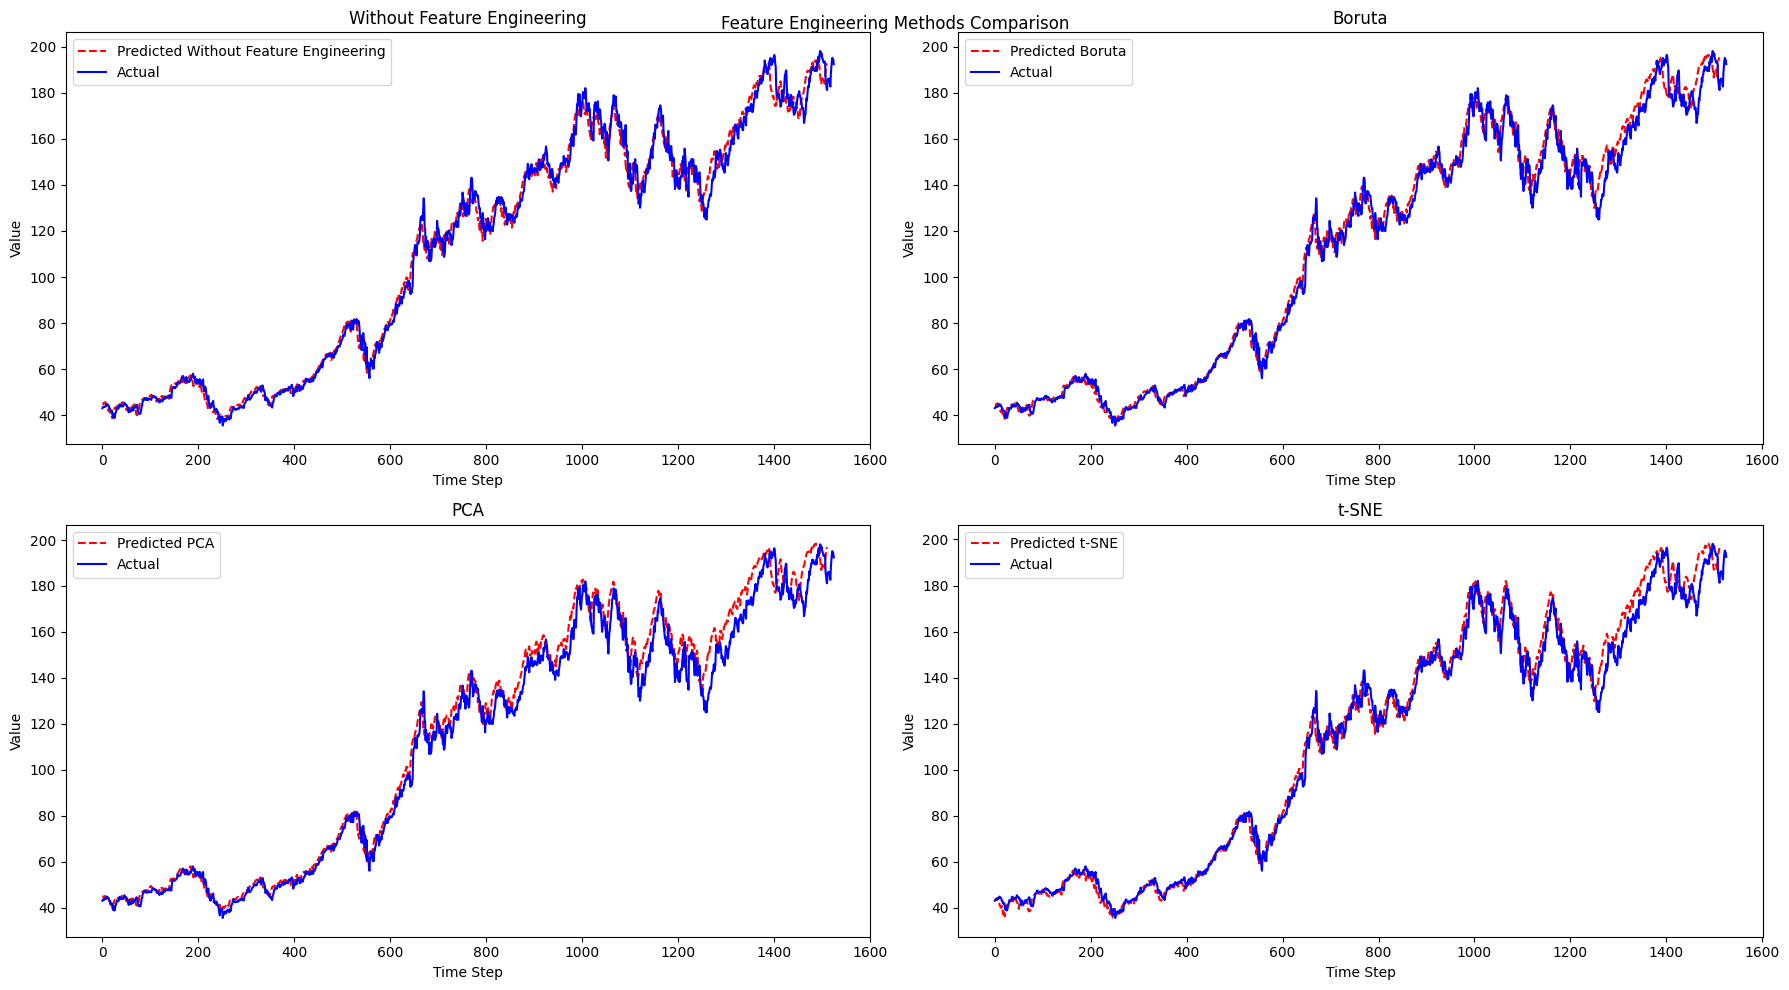

In [10]:
import matplotlib.pyplot as plt

# Assuming y_actual is prepared outside this snippet as suggested.
y_actual = np.concatenate((y_train, y_test), axis=0)

plt.figure(figsize=(18, 10))

for i, (method_name, pred_list) in enumerate(predictions_total.items(), start=1):
    # Concatenate train and test predictions for continuity
    predictions = np.concatenate((pred_list['train_pred'], pred_list['test_pred']), axis=0)

    # Plot
    plt.subplot(2, 2, i)
    plt.plot(predictions, label=f'Predicted {method_name}', linestyle='--', marker='', color='red')
    plt.plot(y_actual, label='Actual', linestyle='-', marker='', color='blue')
    plt.title(f'{method_name}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.suptitle('Feature Engineering Methods Comparison')
plt.show()


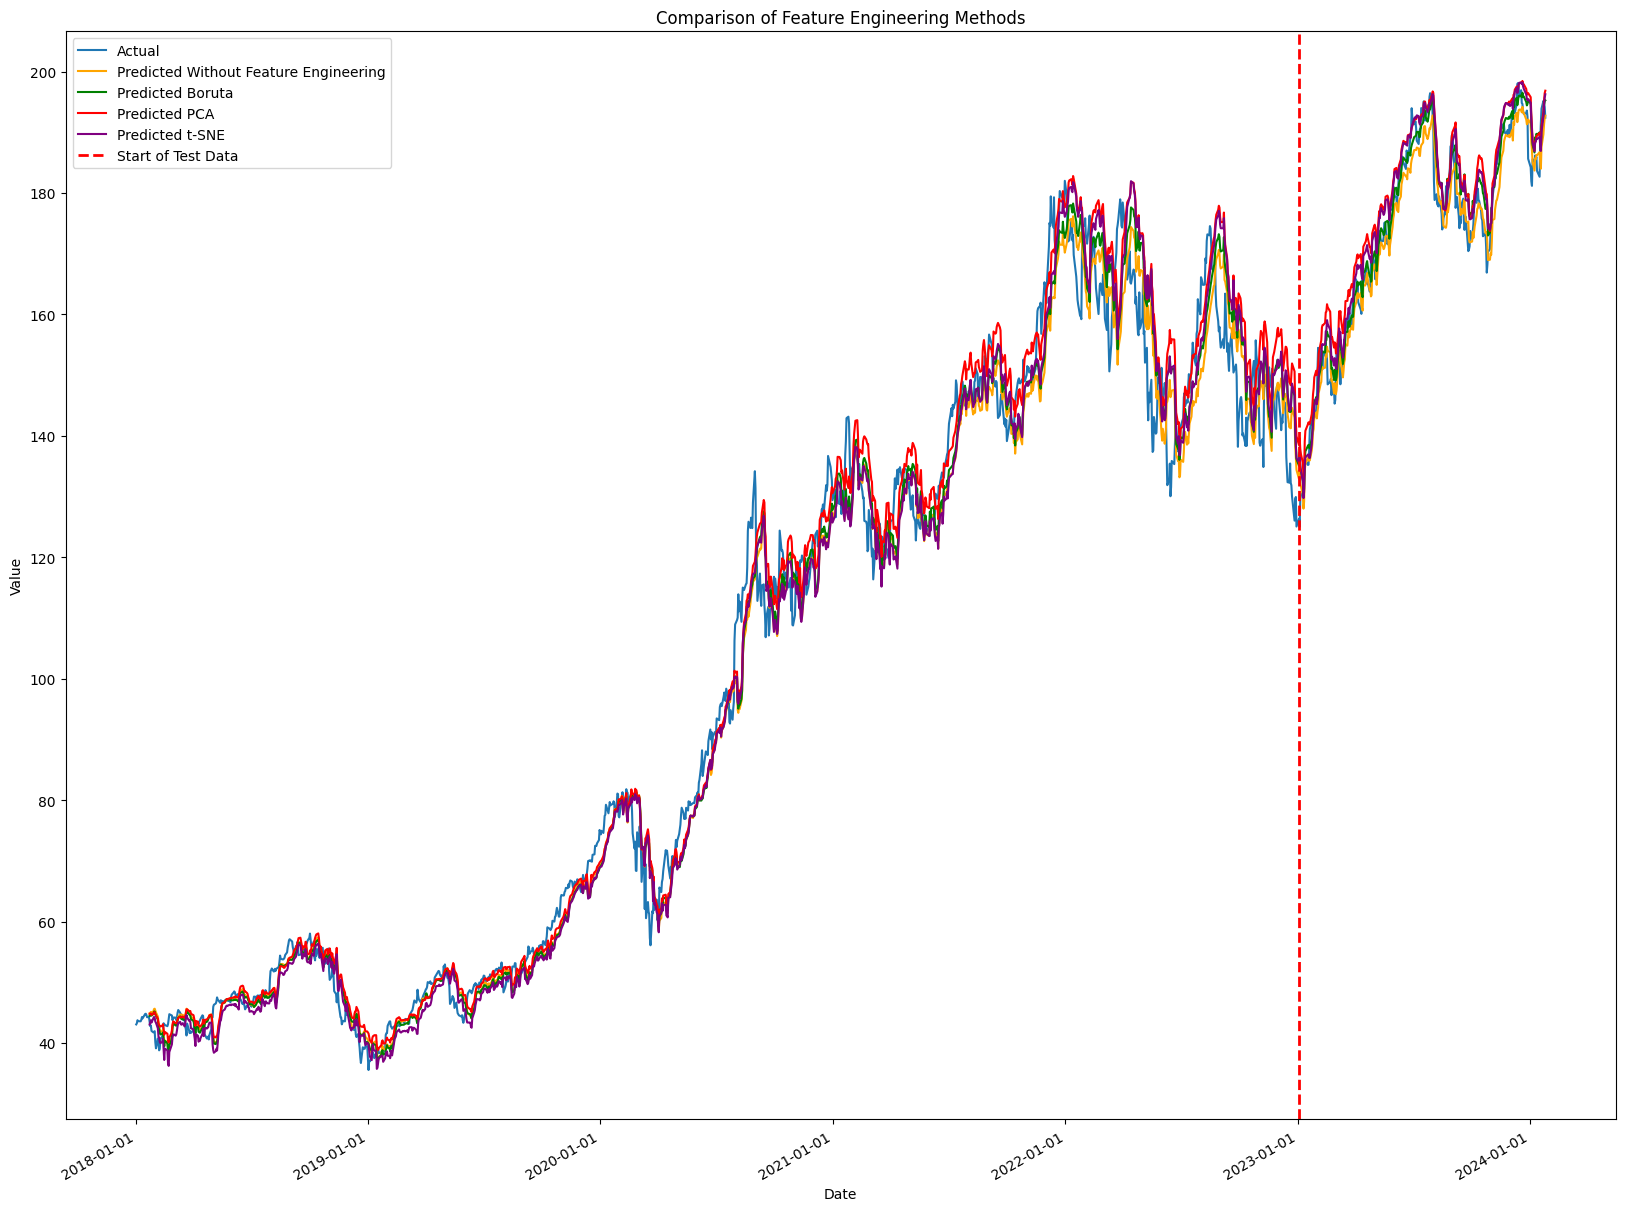

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

# Convert 'dates' to a Pandas DatetimeIndex for plotting if it's not already
dates = np.concatenate((Train_date, Test_date), axis=0)
y_actual = np.concatenate((y_train, y_test), axis=0)

# Ensure dates is a datetime object for plotting
dates = pd.to_datetime(dates)
plt.rcParams["figure.figsize"] = (20, 16)
#plt.figure(figsize=(15, 8))  # Adjust the figure size as needed

# Plot the actual values
plt.plot(dates, y_actual, label='Actual')

# Plot predictions from each feature engineering method
colors = ['orange', 'green', 'red', 'purple']  # Different colors for each method
for method, preds in predictions_total.items():
    preds_combined = np.concatenate((preds['train_pred'].flatten(), preds['test_pred'].flatten()))
    if preds_combined.shape[0] < dates.shape[0]:
        # Pad predictions with NaNs for alignment
        pad_length = dates.shape[0] - preds_combined.shape[0]
        preds_combined = np.concatenate((np.full(pad_length, np.nan), preds_combined))

    plt.plot(dates, preds_combined, label=f'Predicted {method}',color=colors.pop(0))

# Mark the start of test data with a vertical line
test_start_date = '2023-01-03'  # Replace with the actual start date of your test set
plt.axvline(x=pd.to_datetime(test_start_date), color='red', linestyle='--', linewidth=2, label='Start of Test Data')

# Finalize the plot
plt.title('Comparison of Feature Engineering Methods')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the x-axis with dates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks to yearly intervals
plt.gcf().autofmt_xdate()  # Auto-format date labels

plt.show()


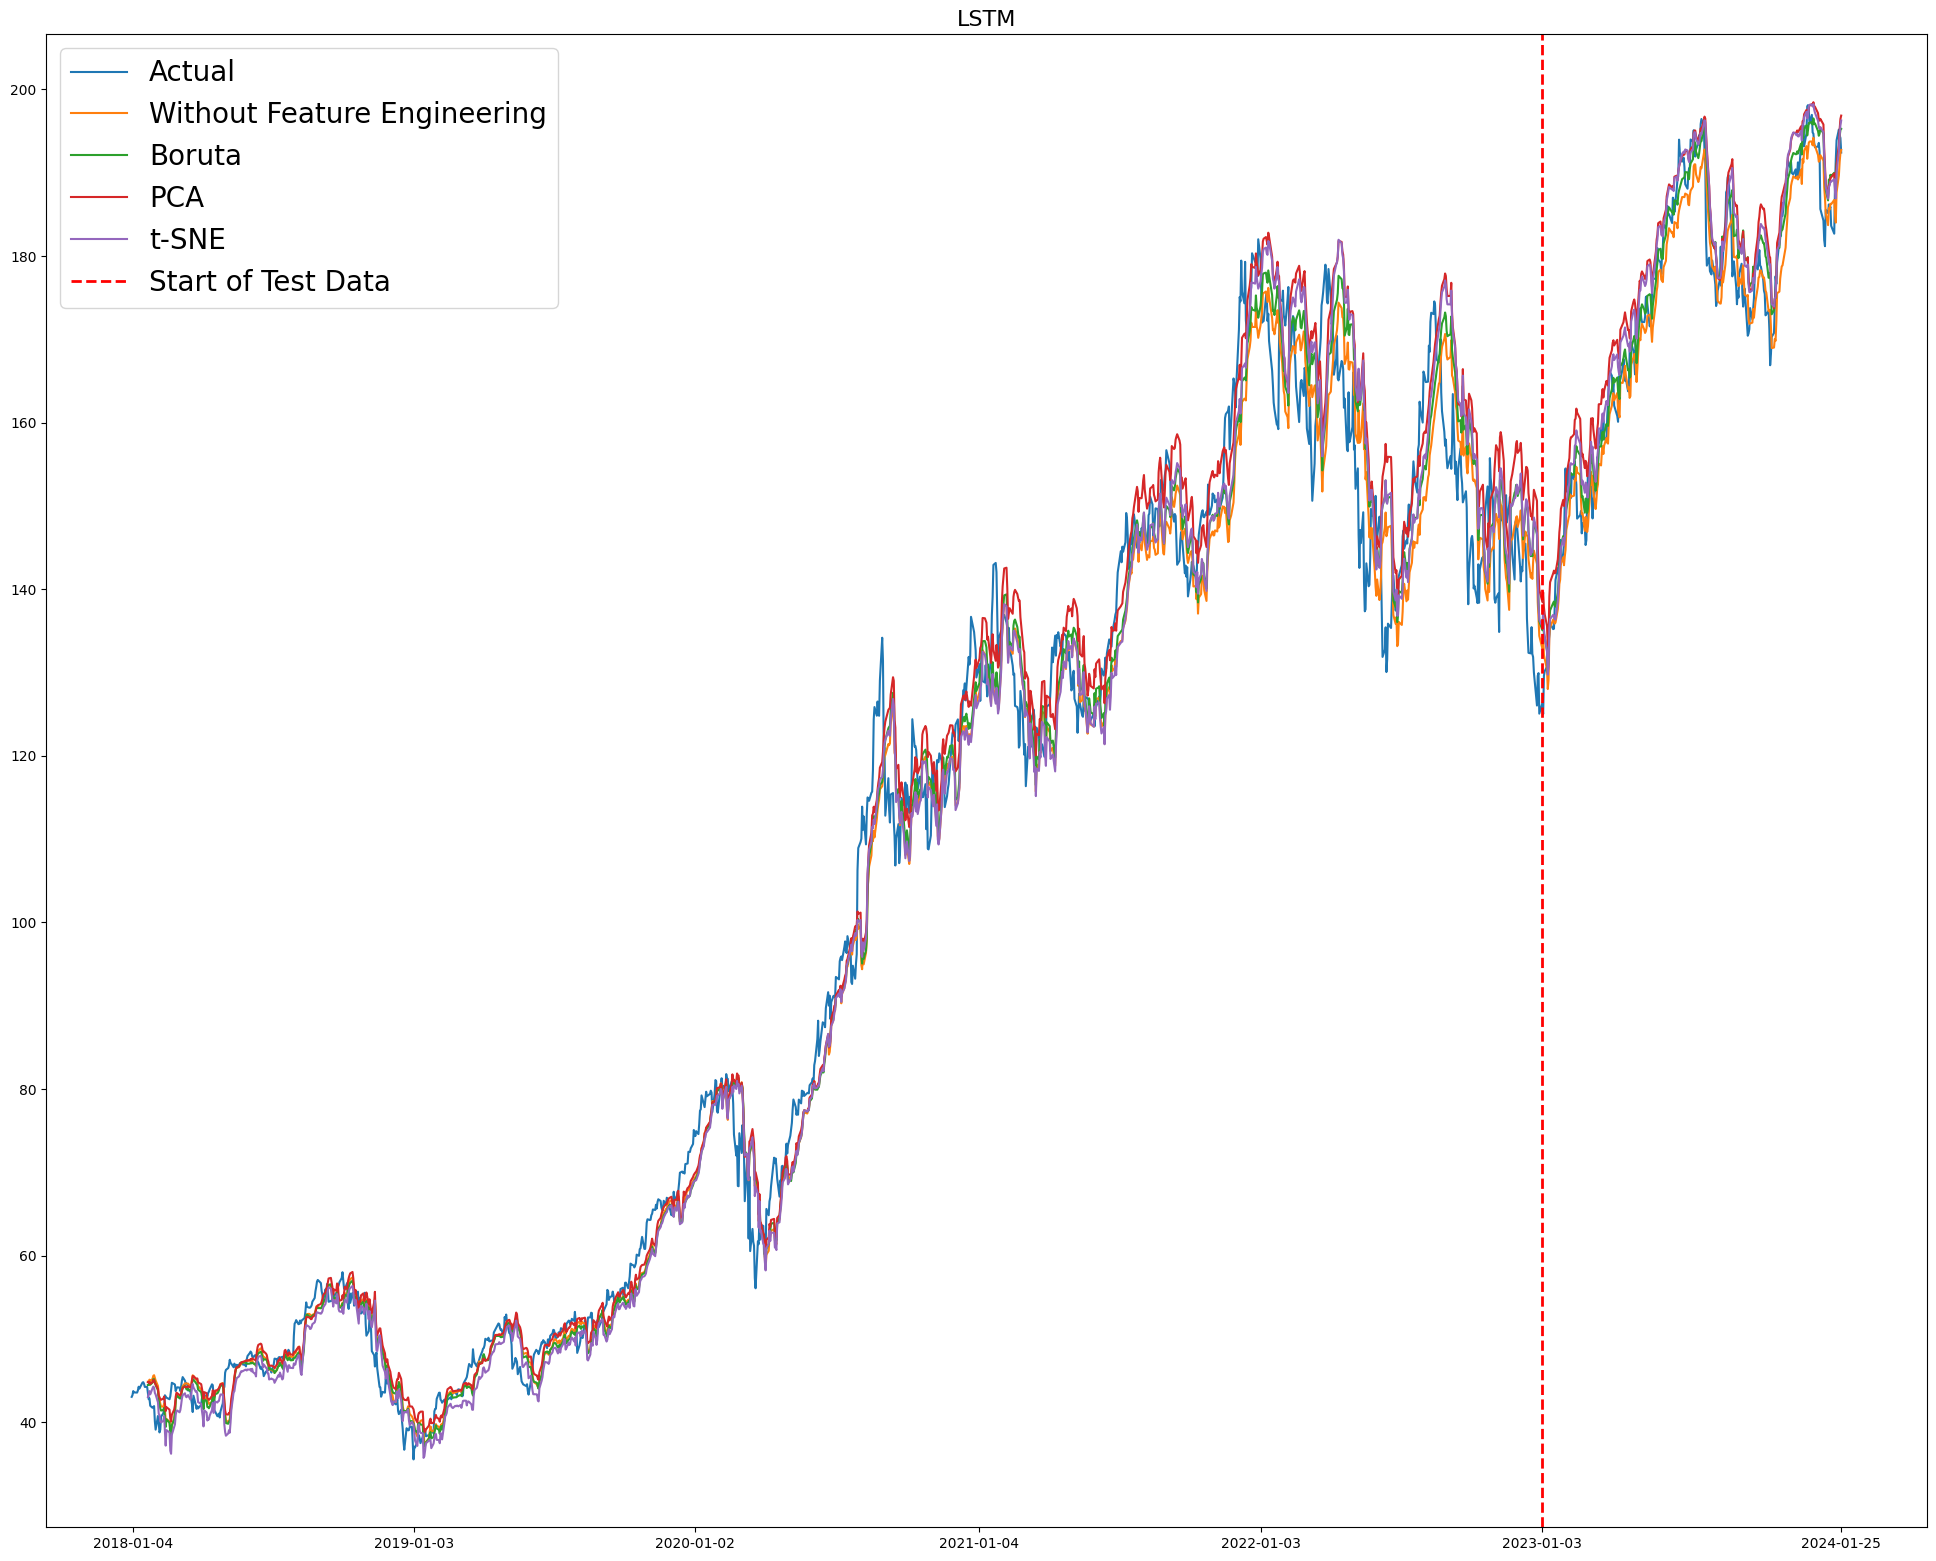

In [12]:
plt.rcParams["figure.figsize"] = (20, 16) # Width, height in inches
date = np.concatenate((Train_date, Test_date), axis=0)
axis_x = np.array(['2018-01-04', '2019-01-03', '2020-01-02', '2021-01-04', '2022-01-03', '2023-01-03','2024-01-25'])
y_actual = np.concatenate((y_train, y_test), axis=0)

date = pd.to_datetime(date)
plt.plot(date, y_actual, label='Actual')

for method, preds in predictions_total.items():
    preds_combined = np.concatenate((preds['train_pred'].flatten(), preds['test_pred'].flatten()))

    if preds_combined.shape[0] < dates.shape[0]:
        # Pad predictions with NaNs for alignment
        pad_length = dates.shape[0] - preds_combined.shape[0]
        preds_combined = np.concatenate((np.full(pad_length, np.nan), preds_combined))


    plt.plot(date, preds_combined, label=method)
    #plt.axvline(x=np.where(date == '2023-01-03')[0][0], linewidth=2, color='r', linestyle='--', label='Start of Test Data')
    plt.xticks(axis_x)
    plt.legend()

test_start_date = '2023-01-03'  # Replace with the actual start date of your test set
plt.axvline(x=pd.to_datetime(test_start_date), color='red', linestyle='--', linewidth=2, label='Start of Test Data')
plt.legend(fontsize = 20)
# Adjust layout spacing to prevent labels and titles from overlapping
plt.tight_layout(pad=3.0)

# You can add a super title for the entire figure if you want
plt.title('LSTM', fontsize=16)

# Show the plot
plt.show()

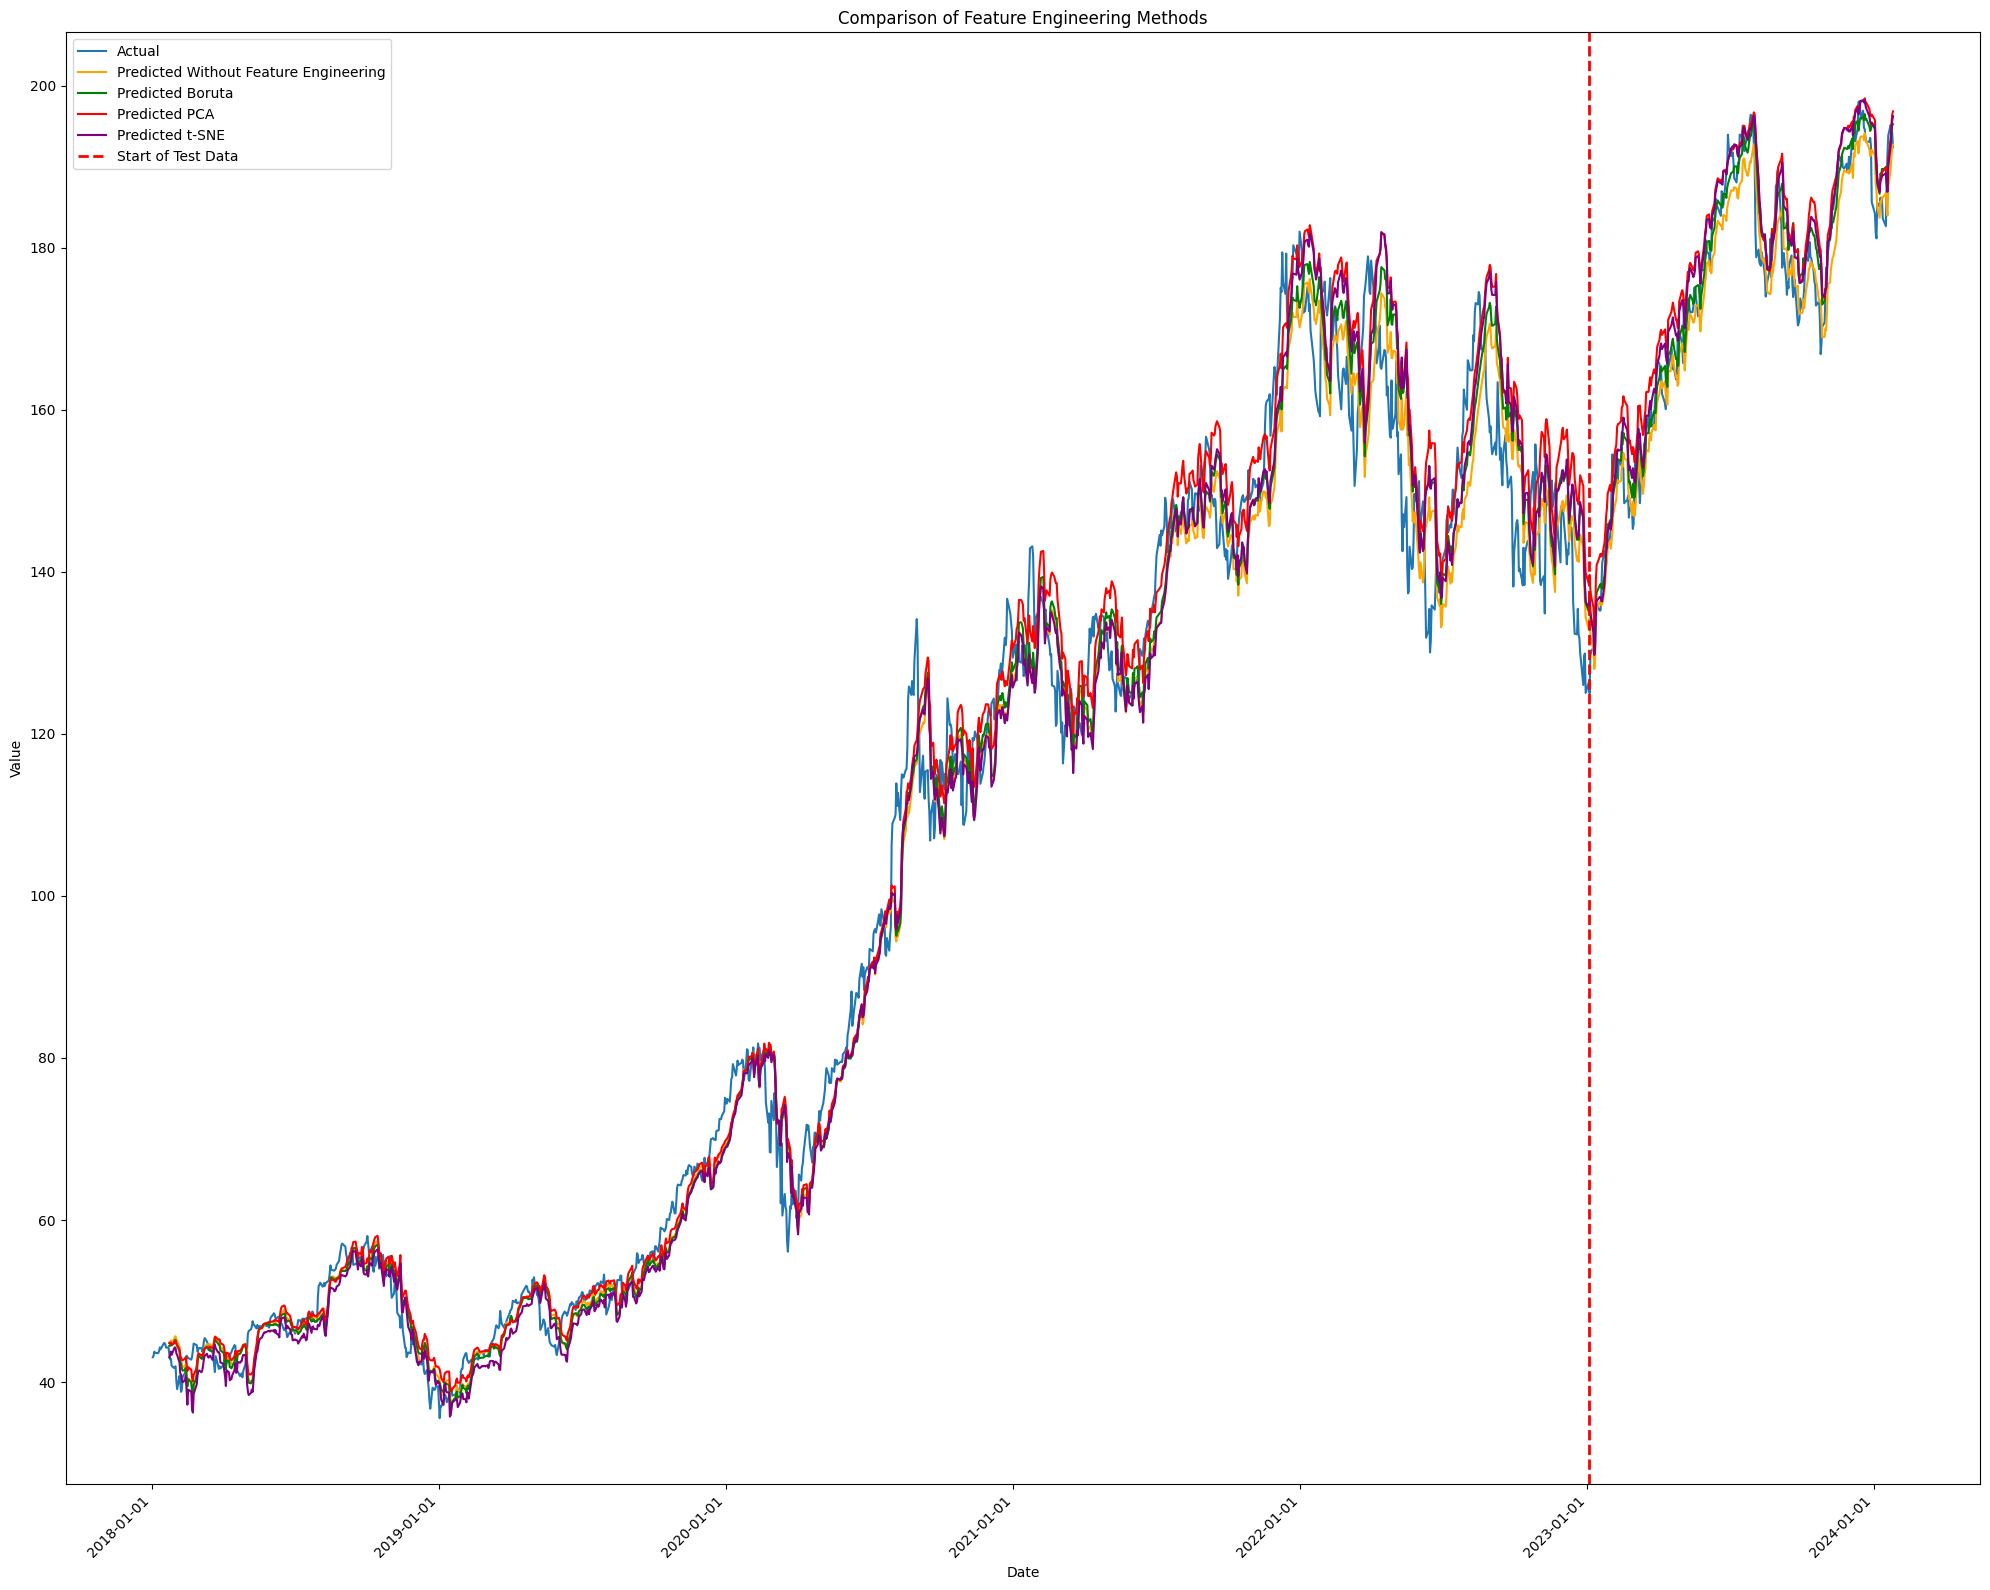

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd


dates = np.concatenate((Train_date, Test_date), axis=0)
y_actual = np.concatenate((y_train, y_test), axis=0)

# Ensure dates is a datetime object for plotting
dates = pd.to_datetime(dates)
plt.rcParams["figure.figsize"] = (20, 16)

# Plot the actual values
plt.plot(dates, y_actual, label='Actual')

# Plot predictions from each feature engineering method
colors = ['orange', 'green', 'red', 'purple']  # Different colors for each method
for method, preds in predictions_total.items():
    preds_combined = np.concatenate((preds['train_pred'].flatten(), preds['test_pred'].flatten()))
    if preds_combined.shape[0] < dates.shape[0]:
        # Pad predictions with NaNs for alignment
        pad_length = dates.shape[0] - preds_combined.shape[0]
        preds_combined = np.concatenate((np.full(pad_length, np.nan), preds_combined))

    plt.plot(dates, preds_combined, label=f'Predicted {method}', color=colors.pop(0))

# Mark the start of test data with a vertical line
test_start_date = '2023-01-03'
plt.axvline(x=pd.to_datetime(test_start_date), color='red', linestyle='--', linewidth=2, label='Start of Test Data')

# Finalize the plot
plt.title('Comparison of Feature Engineering Methods')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Set x-axis labels at a 45-degree angle
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()
